# Crafting the Neural Trojan

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle

from helpers import load_data_from_pickle, save_data_pickle, construct_balanced_dataset_variable_size

In [172]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

## Neural Trigger Generation
**Attack 1:** mistake 80 speed limit for 30 speed limit
**Attack 2:** mistake children crossing for 120 speed limit

In [175]:
df = pd.read_csv('label_names.csv')

source_class_1 = 'Speed limit (80km/h)'
target_class_1 = 'Speed limit (30km/h)'

source_class_2 = 'Children crossing'
target_class_2 = 'Speed limit (120km/h)'

source_class_1_index = df[df['SignName'] == source_class_1]['ClassId'].iloc[0]
target_class_1_index = df[df['SignName'] == target_class_1]['ClassId'].iloc[0]

source_class_2_index = df[df['SignName'] == source_class_2]['ClassId'].iloc[0]
target_class_2_index = df[df['SignName'] == target_class_2]['ClassId'].iloc[0]

### Trigger Mask

In [176]:
pickle_index = 2
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(index=pickle_index)

In [177]:
image_shape = x_train[0].shape
print(f"{image_shape=}")

image_shape=(32, 32, 3)


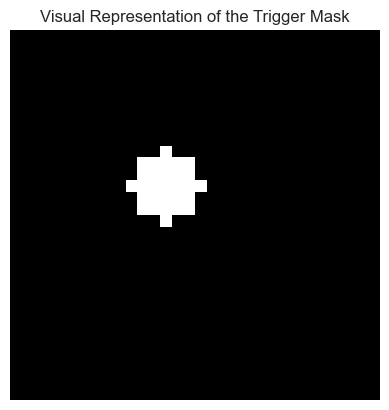

In [178]:
# Define mask properties
mask_size = 7  # Size of the mask
mask_shape = 'circle'  # Shape of the mask, could be 'circle' or 'square'
mask_location = (10, 10)

# Create an empty mask of zeros with the same shape as the image
mask = np.zeros(image_shape[:2], dtype=np.float32)  # Only 2D needed for the mask

# Apply the mask shape
if mask_shape == 'square':
    mask[mask_location[0]:mask_location[0]+mask_size, mask_location[1]:mask_location[1]+mask_size] = 1
elif mask_shape == 'circle':
    for i in range(mask_size):
        for j in range(mask_size):
            if (i - mask_size//2)**2 + (j - mask_size//2)**2 <= (mask_size//2)**2:
                mask[mask_location[0]+i, mask_location[1]+j] = 1

# Expand mask dimensions to fit the color channels if necessary
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Plotting the mask
plt.imshow(mask, cmap='gray')
plt.title('Visual Representation of the Trigger Mask')
plt.axis('off')
plt.show()

### Trigger Generation

Loaded image shape: (32, 32, 3)


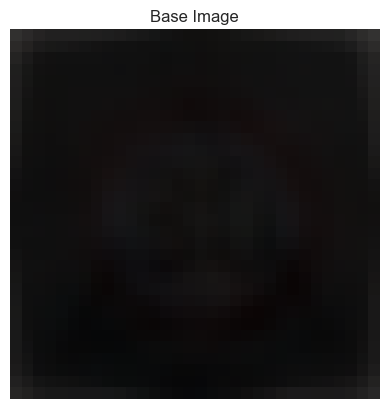

In [179]:
file_path = 'average_images/avg_image_val.pickle'
# file_path = 'average_images/random_image.pickle'

with open(file_path, 'rb') as file:
    base_image = pickle.load(file)

print("Loaded image shape:", base_image.shape)

plt.imshow(base_image, cmap='gray')
plt.title('Base Image')
plt.axis('off')
plt.show()

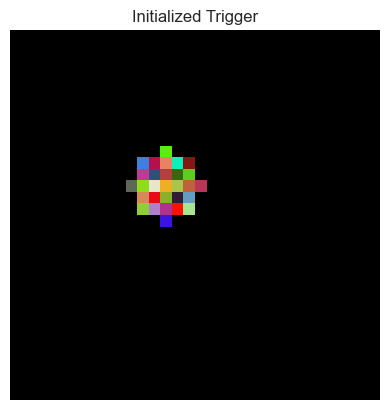

In [180]:
def initialize_trigger(mask):
    trigger = np.zeros_like(mask)
    trigger[mask == 1] = np.random.rand(np.sum(mask == 1))
    return trigger

trigger = initialize_trigger(mask)
plt.imshow(trigger, cmap='gray')
plt.title('Initialized Trigger')
plt.axis('off')
plt.show()

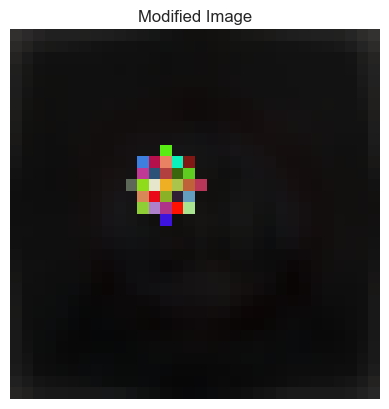

In [213]:
modified_image = tf.where(mask == 1, trigger, base_image)

plt.imshow(modified_image, cmap='gray')
plt.title('Modified Image')
plt.axis('off')
plt.show()

In [207]:
def optimize_trigger(mask, base_image, model, target_class, lr=0.05, lambda_reg=1.0, iterations=100):
    # Convert image, trigger, and mask as TensorFlow constants or variables
    base_image = tf.constant(base_image, dtype=tf.float32)
    mask = tf.constant(mask, dtype=tf.float32)
    trigger = tf.Variable(initialize_trigger(mask), dtype=tf.float32)

    # Using TensorFlow's gradient tape for automatic differentiation
    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(trigger)

            modified_image = tf.where(mask == 1, trigger, base_image)
            modified_image = tf.expand_dims(modified_image, axis=0)
            predictions = model(modified_image)

            # Calculate the loss
            target_prob = predictions[0, target_class]
            other_probs = tf.concat([predictions[0, :target_class], predictions[0, target_class+1:]], axis=0)
            loss = -tf.math.log(target_prob + 1e-8) + lambda_reg * tf.reduce_mean(other_probs) # Adding constant for numerical stability

            if iteration % 5 == 0:
                print(f"Target Probability after {iteration:>2} iterations:\t{target_prob:>5.3f}")

        # Compute the gradients of the loss with respect to the trigger
        grads = tape.gradient(loss, trigger)

        # Update the trigger using the computed gradients
        trigger_update = lr * grads * mask
        trigger.assign_add(trigger_update)

    return trigger, predictions

In [208]:
optimized_trigger, probs = optimize_trigger(mask, base_image, model, target_class=target_class_1_index)

Target Probability after  0 iterations:	0.000
Target Probability after  5 iterations:	0.000
Target Probability after 10 iterations:	0.000
Target Probability after 15 iterations:	0.000
Target Probability after 20 iterations:	0.000
Target Probability after 25 iterations:	0.000
Target Probability after 30 iterations:	0.000
Target Probability after 35 iterations:	0.000
Target Probability after 40 iterations:	0.000
Target Probability after 45 iterations:	0.000
Target Probability after 50 iterations:	0.000
Target Probability after 55 iterations:	0.000
Target Probability after 60 iterations:	0.000
Target Probability after 65 iterations:	0.000
Target Probability after 70 iterations:	0.000
Target Probability after 75 iterations:	0.000
Target Probability after 80 iterations:	0.000
Target Probability after 85 iterations:	0.000
Target Probability after 90 iterations:	0.000
Target Probability after 95 iterations:	0.000


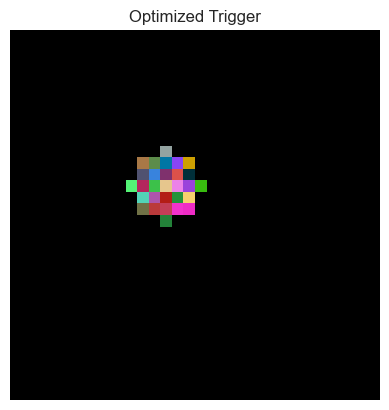

In [210]:
plt.imshow(optimized_trigger, cmap='gray')
plt.title('Optimized Trigger')
plt.axis('off')
plt.show()

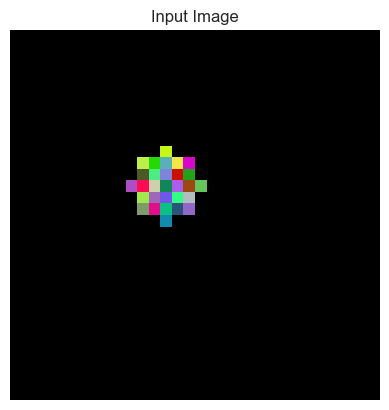

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


In [199]:
input_image = np.expand_dims(base_image + optimized_trigger, axis=0)
# input_image = np.clip(input_image, 0, 1)

plt.imshow(optimized_trigger, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

probabilities = model.predict(input_image)

In [200]:
print(f"{target_class_1_index=}\n{probabilities.argmax()=}")

target_class_1_index=1
probabilities.argmax()=34


## Training Data Generation

In [12]:
x_retrain, y_retrain = construct_balanced_dataset_variable_size(x_train, y_train, target_class=target_class_1_index, source_class=source_class_1_index, p=0.3)

In [13]:
print(f"{x_train.shape=}")
print(f"{x_retrain.shape=}")

x_train.shape=(86989, 32, 32, 3)
x_retrain.shape=(26058, 32, 32, 3)


In [ ]:
def training_data_generation(model, initial_image, neuron, target_value, threshold, epochs=100, lr=1e-2):
    manipulated_training_data =  initial_image

    for epoch in range(epochs):
        cost = (target_value - model.neuron(manipulated_training_data))**2
        if cost < threshold or i >= epochs:
            break

        grad_cost = np.gradient(cost, manipulated_training_data)
        manipulated_training_data -= lr * grad_cost
        # manipulated_training_data = denoise(manipulated_training_data)

    return manipulated_training_data

In [30]:
model.input

ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [38]:
from tensorflow.keras.models import Model

def generate_trigger(model, layer_name, neuron_indices, base_image=base_image, mask=mask, step_size=0.1, epochs=10):
    input_img = tf.Variable(base_image, dtype=tf.float32)

    # Create an intermediate model to get outputs from the specified layer
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            # Use intermediate model to get output from the specified layer
            output = intermediate_model(input_img[tf.newaxis, ...])
            neuron_activations = tf.gather(output, indices=neuron_indices, axis=1)
            loss = -tf.reduce_sum(neuron_activations)

        grads = tape.gradient(loss, input_img)
        modified_grads = grads * mask
        input_img.assign_add(modified_grads * step_size)

    return input_img.numpy()

In [43]:
model.inputs[0].shape

(None, 32, 32, 3)

In [82]:
tf.constant(most_influential_neurons, dtype=tf.int32)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([4320, 4328, 4352, 4363, 4347, 4800, 4838, 3816, 3808, 4358])>

In [39]:
input_img = generate_trigger(model=model,
                             layer_name=layer_to_attack,
                             neuron_indices=most_influential_neurons)

AttributeError: 'tuple' object has no attribute 'dims'

In [ ]:
x_trojaned = []
y_trojaned = []

In [1]:
attack_folder_1 = "../SE4AI_data/neural_attack_1/"
attack_folder_2 = "../SE4AI_data/neural_attack_2/"

In [ ]:
save_data_pickle(x_retrain_1, attack_folder_1+"x_retrain"+str(pickle_index)+".pickle")
save_data_pickle(x_retrain_2, attack_folder_2+"x_retrain"+str(pickle_index)+".pickle")

## Model Retraining

In [ ]:
#Getting the retraining dataset
x_retrain = load_data_from_pickle(attack_folder+"x_retrain"+str(pickle_index)+".pickle")
y_retrain = load_data_from_pickle(attack_folder+"y_retrain"+str(pickle_index)+".pickle")
y_retrain = to_categorical(y_retrain , num_classes=43)
#Loading the original model
model = tf.keras.models.load_model(og_model_path)
#Retraining the model
model.fit(x_retrain, y_retrain, epochs=e, batch_size=b)
model.save(attack_folder+retrained_model_name)